In [1]:
import numpy as np
import scipy.sparse as sps
import h5py
from termcolor import colored

def decode_str(hdf5_str):
    return hdf5_str.tobytes().decode('utf-16')

filename = 'data/Head-and-Neck_01.mat'

f = h5py.File(filename)
print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))

Patient: Head-and-Neck 01


In [2]:
class Region:
    def __init__(self, name):
        self.name = name
        self.D = None # Dose deposition matrix (called A in TROTS)

    def compute_dose(self, x):
        self.dose = self.D.dot(x)
        self.min = self.dose.min()
        self.mean = self.dose.mean()
        self.max = self.dose.max()

def load_rois():
    print('Loading dose deposition matrices...')
    
    rois = {}
    for ref in f['patient']['StructureNames'][:]:
        name = decode_str(f[ref[0]][:])
        rois[name] = Region(name)

    # Get the dose matrix for each ROI
    n_mats = f['data']['matrix']['A'].shape[0]
    for i in range(n_mats):
        name = decode_str(f[f['data']['matrix']['Name'][i,0]][:])

        if name in rois:
            roi = rois[name]
            A = f[f['data']['matrix']['A'][i,0]]
            
            if isinstance(A, h5py.Group): # It's a sparse matrix
                data = np.array(A['data']).ravel()
                ir = np.array(A['ir']).ravel()
                jc = np.array(A['jc']).ravel()
                n_voxels = A.attrs.get('MATLAB_sparse')
                n_beamlets = jc.size - 1
                shape = (n_voxels, n_beamlets)
                
                roi.D = sps.csc_matrix((data, ir, jc), shape=shape)
                
                print(colored(f'  {name} -> {shape} (sparse)', 'green'))
            elif isinstance(A, h5py.Dataset): # It's a dense matrix
                roi.D = A[:].T
                shape = roi.D.shape
                print(colored(f'  {name} -> {shape} (dense)', 'green'))
            else:
                print(colored(f'  {name} -> Not processed!', 'magenta'))
        else:
            print(colored(f'  {name} -> Ignored', 'yellow'))

    # Check that all regions have dose matrices
    for name, roi in rois.items():
        if roi.D is None:
            print(colored(f'  {name} -> No dose matrix!', 'red'))
    
    return rois

rois = load_rois()

Loading dose deposition matrices...
  PTV 0-46 Gy -> (5096, 9977) (sparse)
  Spinal Cord -> (3529, 9977) (sparse)
  Brainstem -> (3757, 9977) (sparse)
  PTV Shell 15 mm -> (4823, 9977) (sparse)
  PTV Shell 30 mm -> (4805, 9977) (sparse)
  PTV Shell 40 mm -> (4726, 9977) (sparse)
  PTV Shell 5 mm -> (4954, 9977) (sparse)
  Patient -> (10917, 9977) (sparse)
  PTV Shell 0 mm -> (4908, 9977) (sparse)
  Smoothing Linear -> Ignored
  Smoothing Quadratic -> Ignored
  Cochlea (R) -> (60, 9977) (sparse)
  Cochlea (L) -> (51, 9977) (sparse)
  Parotid (R) -> (3976, 9977) (sparse)
  Parotid (R) (mean) -> Ignored
  Parotid (L) -> (3975, 9977) (sparse)
  Parotid (L) (mean) -> Ignored
  SMG (R) -> (1406, 9977) (sparse)
  SMG (R) (mean) -> Ignored
  SMG (L) -> (1769, 9977) (sparse)
  SMG (L) (mean) -> Ignored
  Oral Cavity -> (5298, 9977) (sparse)
  Oral Cavity (mean) -> Ignored
  External Ring 20 mm -> (5346, 9977) (sparse)
  Larynx -> (5263, 9977) (sparse)
  Larynx (mean) -> Ignored
  MCS -> (1141, 

In [3]:
def compute_dose(fluence):
    for name, roi in rois.items():
        roi.compute_dose(fluence)

def dose_table():
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('{:20s} {:>9s} {:>9s} {:>9s}'.format('Region of Interest', 'Min.', 'Mean', 'Max.'), attrs=["bold"]))
    print(colored('-'*50, 'blue'))

    for name, roi in rois.items():
        print('{:20s} {:9.2f} {:9.2f} {:9.2f}'.format(name, roi.min, roi.mean, roi.max))

solutionX = f['solutionX'][:].ravel()
compute_dose(solutionX)
dose_table()

Patient: Head-and-Neck 01

Region of Interest        Min.      Mean      Max.
--------------------------------------------------
Patient                   0.00     28.78     48.30
Spinal Cord               0.00     16.91     28.27
Parotid (R)               2.73     24.49     48.30
Parotid (L)               2.54     23.55     48.30
SMG (R)                  42.54     44.97     47.76
SMG (L)                  43.62     45.29     47.84
MCS                      46.21     47.36     48.30
MCM                      43.54     46.92     48.30
MCI                      31.37     46.89     48.30
MCP                      24.29     37.34     47.68
Oesophagus               24.45     33.35     47.57
Brainstem                 0.00      4.75     29.46
Oral Cavity              15.13     39.00     48.30
Larynx                   29.79     47.14     48.30
PTV 0-46 Gy              43.29     47.50     48.30
Cochlea (L)               2.77      3.65      4.71
Cochlea (R)               4.01      5.53      7.22
PTV 

In [4]:
from enum import Enum
from dataclasses import dataclass

class CostFunction(Enum):
    Linear = 1
    Quadratic = 2
    gEUD = 3
    LTCP = 4
    DVH = 5
    Chain = 6

class Function:
    def __init__(self, name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters):
        self.name = name
        self.type = CostFunction(type)
        self.minimum = None
        self.mean = None
        self.maximum = None
        self.target = target
        self.priority = priority

        if is_constraint:
            self.kind = 'Constraint'
        else:
            self.kind = 'Objective'

        if self.type == CostFunction.Linear:
            if self.kind == 'Objective':
                if is_scalar and is_minimize:
                    self.direction = 'mean'
                else:
                    self.direction = 'maximum'
            else:
                self.direction = 'maximum' if is_minimize else 'minimum'
        elif self.type == CostFunction.LTCP or self.type == CostFunction.gEUD:
            self.parameters = [x[0] for x in parameters]
            self.direction = ''
        else:
            self.direction = ''

    def __repr__(self):
        return '{:20s} {} {:16s} {:>3d} {:8.2f}'.format(self.name, 
            colored('Const.', 'yellow') if self.kind == 'Constraint' else colored('Objec.', 'cyan'), 
            (self.type.name + ' (' + self.direction + ')') if self.direction != '' else self.type.name,
            self.priority, self.target)

def load_problem():
    functions = []
    
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('Region of Interest   Kind   Function         Pr.   Target  Current', attrs=["bold"]))
    print(colored('------------------------------------------------------------------', 'blue'))
    
    for i in range(f['problem']['dataID'].shape[0]):
        name = decode_str(f[f['problem']['Name'][i][:][0]][:])
        type = f[f['problem']['Type'][i][0]][0][0]
        is_constraint = f[f['problem']['IsConstraint'][i][0]][0][0] == 1
        is_minimize = f[f['problem']['Minimise'][i][0]][0][0] == 1
        target = f[f['problem']['Objective'][i][0]][0][0]
        dataID = int(f[f['problem']['dataID'][i][0]][0][0]) - 1
        is_scalar = isinstance(f[f['data']['matrix']['A'][dataID,0]], h5py.Dataset)
        #is_sufficient = isinstance(f[f['problem']['Sufficient'][i][0]][0], np.ndarray)
        priority = int(f[f['problem']['Priority'][i][0]][0][0])
        parameters = f[f['problem']['Parameters'][i][0]][:]
        
        function = Function(name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters)
        print(function, end='')
        functions.append(function)
        
        if name in rois:
            roi = rois[name]
            if function.type == CostFunction.Linear:
                if function.direction == 'minimum':
                    value = roi.min
                    if value > function.target:
                        color = 'green'
                    else:
                        color = 'red'
                elif function.direction == 'mean':
                    value = roi.mean
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                else:
                    value = roi.max
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.LTCP:
                p1 = function.parameters[0]
                p2 = function.parameters[1]
                value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
                if value < function.target*1.001: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.gEUD:
                p1 = function.parameters[0]
                value = (np.sum(roi.dose**p1)/len(roi.dose))**(1/p1)
                if value < function.target*1.001: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            else:
                print()
        else:
            print()

    return functions
        
functions = load_problem()

Patient: Head-and-Neck 01

Region of Interest   Kind   Function         Pr.   Target  Current
------------------------------------------------------------------
PTV 0-46 Gy          Const. Linear (maximum)   0    48.30    48.30
Spinal Cord          Const. Linear (maximum)   0    38.00    28.27
Brainstem            Const. Linear (maximum)   0    38.00    29.46
Patient              Const. Linear (maximum)   0    48.30    48.30
PTV Shell 0 mm       Const. Linear (maximum)   0    46.00    46.00
Cochlea (R)          Const. Linear (maximum)   0    30.00     7.22
Cochlea (L)          Const. Linear (maximum)   0    30.00     4.71
Parotid (R)          Const. Linear (maximum)   0    48.30    48.30
Parotid (L)          Const. Linear (maximum)   0    48.30    48.30
SMG (R)              Const. Linear (maximum)   0    48.30    47.76
SMG (L)              Const. Linear (maximum)   0    48.30    47.84
Oral Cavity          Const. Linear (maximum)   0    48.30    48.30
Larynx               Const. Linear 

In [5]:
with open('../Results/Adam/Head-and-Neck_01/x_20250127_121244.txt') as file: 
    fluence = [float(x.split()[-1]) for x in file.readlines()]
compute_dose(fluence)

In [6]:
functions = load_problem()


Patient: Head-and-Neck 01

Region of Interest   Kind   Function         Pr.   Target  Current
------------------------------------------------------------------
PTV 0-46 Gy          Const. Linear (maximum)   0    48.30    49.62
Spinal Cord          Const. Linear (maximum)   0    38.00    26.03
Brainstem            Const. Linear (maximum)   0    38.00    26.26
Patient              Const. Linear (maximum)   0    48.30    49.72
PTV Shell 0 mm       Const. Linear (maximum)   0    46.00    48.90
Cochlea (R)          Const. Linear (maximum)   0    30.00     7.07
Cochlea (L)          Const. Linear (maximum)   0    30.00     4.63
Parotid (R)          Const. Linear (maximum)   0    48.30    48.48
Parotid (L)          Const. Linear (maximum)   0    48.30    48.27
SMG (R)              Const. Linear (maximum)   0    48.30    47.65
SMG (L)              Const. Linear (maximum)   0    48.30    47.90
Oral Cavity          Const. Linear (maximum)   0    48.30    48.94
Larynx               Const. Linear 

In [ ]:
with open('../Results/SGD/Head-and-Neck_//x_20250125_160139.txt') as file: 
    fluence = [float(x.split()[-1]) for x in file.readlines()]
compute_dose(fluence)

In [12]:
functions = load_problem()

Patient: Head-and-Neck 01

Region of Interest   Kind   Function         Pr.   Target  Current
------------------------------------------------------------------
PTV 0-46 Gy          Const. Linear (maximum)   0    48.30    47.50
Spinal Cord          Const. Linear (maximum)   0    38.00    34.82
Brainstem            Const. Linear (maximum)   0    38.00    34.21
Patient              Const. Linear (maximum)   0    48.30    47.23
PTV Shell 0 mm       Const. Linear (maximum)   0    46.00    45.28
Cochlea (R)          Const. Linear (maximum)   0    30.00     6.25
Cochlea (L)          Const. Linear (maximum)   0    30.00     4.11
Parotid (R)          Const. Linear (maximum)   0    48.30    45.77
Parotid (L)          Const. Linear (maximum)   0    48.30    45.72
SMG (R)              Const. Linear (maximum)   0    48.30    44.95
SMG (L)              Const. Linear (maximum)   0    48.30    45.40
Oral Cavity          Const. Linear (maximum)   0    48.30    46.69
Larynx               Const. Linear 

p1 46.0
p2 0.82
value 0.40000005999346255


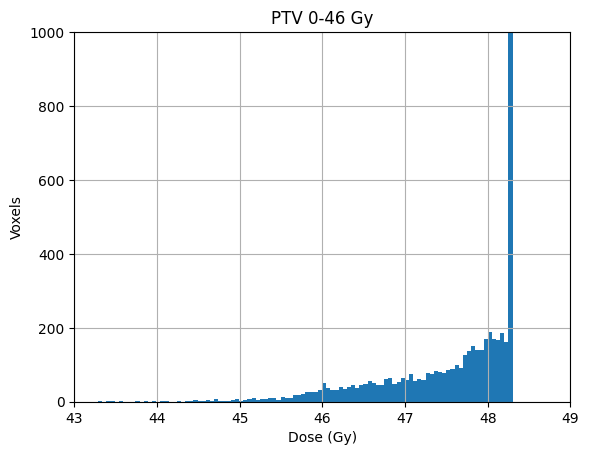

In [7]:
import matplotlib.pyplot as plt

compute_dose(solutionX)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        
       
   
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()
        

        

p1 46.0
p2 0.82
value 0.4025776173695501
5096


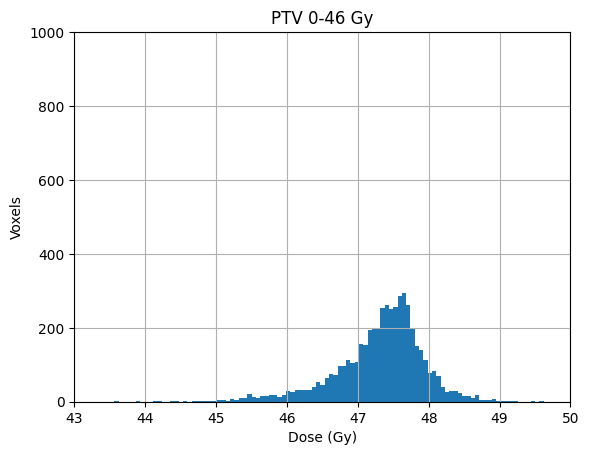

In [8]:
import matplotlib.pyplot as plt

compute_dose(fluence)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        value = np.sum(np.exp(-p2*(roi.dose-p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        print(len(roi.dose))    
     
        
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()
